In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Define Training Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
n_classes = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Load Input/Ouput Data

In [3]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [4]:
def scale_and_shift_flat(x, labels, reuse=True):
    with tf.variable_scope("scale_and_shift", reuse=reuse):
        axis = [1,2]
        x_shape = x.get_shape().as_list()
        beta = tf.get_variable( 'beta', [n_classes])
        gamma = tf.get_variable( 'gamma', [n_classes])
        
        class_shift = tf.gather(beta, labels)
        print(f'class_shift shape: {class_shift.get_shape().as_list()}')
        class_shift = tf.expand_dims(class_shift, 1)
        print(f'class_shift shape: {class_shift.get_shape().as_list()}')
        
        class_scale = tf.gather(gamma, labels)
        print(f'class_scale shape: {class_scale.get_shape().as_list()}')
        class_scale = tf.expand_dims(class_scale, 1)
        print(f'class_scale shape: {class_scale.get_shape().as_list()}')
        
        print(f'Prior x shape: {x.get_shape().as_list()}')
        output = x + class_shift
        print(f'output int1 shape: {output.get_shape().as_list()}')
        output *= class_scale
        print(f'output final shape: {output.get_shape().as_list()}\n')
        return output
        

In [5]:
def scale_and_shift(x, labels, reuse=True):
    with tf.variable_scope("scale_and_shift", reuse=reuse):
        axis = [1,2]
        x_shape = x.get_shape().as_list()
        # print(f'x shape: {x_shape}')
        beta = tf.get_variable( 'beta', [n_classes])# ,
                                     # initializer=tf.zeros_initializer())
        # print(f'beta shape: {beta.get_shape().as_list()}')
        gamma = tf.get_variable( 'gamma', [n_classes])#,
                                    # initializer=tf.ones_initializer())
        # print(f'gamma shape: {gamma.get_shape().as_list()}')
        
        class_shift = tf.gather(beta, labels)
        print(f'class_shift shape: {class_shift.get_shape().as_list()}')
        class_shift = tf.expand_dims(tf.expand_dims(tf.expand_dims(class_shift, 1), 1), 1)
        print(f'class_shift shape: {class_shift.get_shape().as_list()}')
        
        class_scale = tf.gather(gamma, labels)
        print(f'class_scale shape: {class_scale.get_shape().as_list()}')
        class_scale = tf.expand_dims(tf.expand_dims(tf.expand_dims(class_scale, 1), 1), 1)
        print(f'class_scale shape: {class_scale.get_shape().as_list()}')
        
        print(f'Prior x shape: {x.get_shape().as_list()}')
        output = x + class_shift
        print(f'output int1 shape: {output.get_shape().as_list()}')
        output *= class_scale
        print(f'output final shape: {output.get_shape().as_list()}\n')
        
#         mean, variance = tf.nn.moments(x, axis, keep_dims=True)
#         print(f'mean shape: {mean.get_shape().as_list()}')
#         print(f'variance shape: {variance.get_shape().as_list()}')
        
#         moments_shape = tf.shape(mean)
#         mu = tf.zeros(moments_shape)
#         sigma = tf.ones(moments_shape)
#         print(f'mu shape: {mu.get_shape().as_list()}')
#         print(f'sigma shape: {sigma.get_shape().as_list()}')
        
#         variance_epsilon = 0.01
# #         output = tf.nn.batch_normalization(x=x, mean=conditioned_shift,
# #                                            variance=conditioned_scale,
# #                                            offset=None, scale=None,
# #                                            variance_epsilon=variance_epsilon)
#         output = tf.nn.batch_normalization(x=x, mean=mu,
#                                            variance=sigma,
#                                            offset=conditioned_shift, scale=conditioned_scale,
#                                            variance_epsilon=variance_epsilon)
#         print(f'output shape: {output.get_shape().as_list()}')
        return output

    

In [6]:
def encoder(X_in, labels, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(f'x shape: {tf.shape(x)}')
        x = scale_and_shift(x, labels, reuse=False)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = scale_and_shift(x, labels, reuse=True)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.contrib.layers.flatten(x)
        print(f'final x: {x.get_shape().as_list()}')
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        return z, mn, sd

In [7]:
def decoder(sampled_z, labels, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        print(f'First x shape: {x.get_shape().as_list()}')
        x = scale_and_shift_flat(x, labels, reuse=False)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.dense(x, units=(inputs_decoder * 2 + 1), activation=lrelu)
        x = scale_and_shift_flat(x, labels, reuse=True)
        x = tf.reshape(x, reshaped_dim)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels)
        x = tf.nn.dropout(x, keep_prob)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels)
        x = tf.nn.dropout(x, keep_prob)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

### Initialize

In [22]:
tf.reset_default_graph()

batch_size = 4
n_classes = 10

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='X')
Labels = tf.placeholder(dtype=tf.int32, shape=[None], name='Labels')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')
print(f'Y_flat: {Y_flat.get_shape().as_list()}')
print(f'Labels: {Labels.get_shape().as_list()}')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2

sampled, mn, sd = encoder(X_in, Labels, keep_prob)
dec = decoder(sampled, Labels, keep_prob)
print(f'dec: {dec.get_shape().as_list()}')

unreshaped = tf.reshape(dec, [-1, 28*28])
print(f'unreshaped: {unreshaped.get_shape().as_list()}')
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)

# introduce variable learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.0005
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Y_flat: [None, 784]
Labels: [None]
x shape: Tensor("encoder/Shape:0", shape=(4,), dtype=int32)
class_shift shape: [None]
class_shift shape: [None, 1, 1, 1]
class_scale shape: [None]
class_scale shape: [None, 1, 1, 1]
Prior x shape: [None, 14, 14, 64]
output int1 shape: [None, 14, 14, 64]
output final shape: [None, 14, 14, 64]

class_shift shape: [None]
class_shift shape: [None, 1, 1, 1]
class_scale shape: [None]
class_scale shape: [None, 1, 1, 1]
Prior x shape: [None, 7, 7, 64]
output int1 shape: [None, 7, 7, 64]
output final shape: [None, 7, 7, 64]

final x: [None, 3136]
First x shape: [None, 24]
class_shift shape: [None]
class_shift shape: [None, 1]
class_scale shape: [None]
class_scale shape: [None, 1]
Prior x shape: [None, 24]
output int1 shape: [None, 24]
output final shape: [None, 24]

x shape: [None, 24]
class_shift shape: [None]
class_shift shape: [None, 1]
class_scale shape: [None]
class_scale shape: [None, 1]
Prior x shape: [None, 49]
output int1 shape: [None, 49]
output fina

### Train

##### Variable Learning Rate

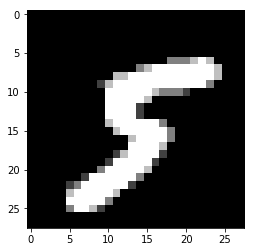

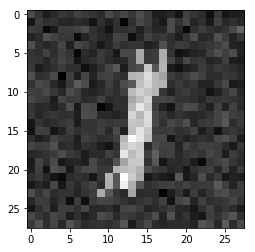

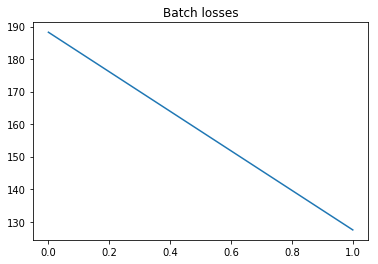

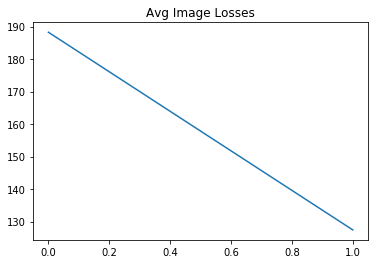

iteration: 0; batch loss: 127.4605941772461, mean img loss: 127.4590072631836


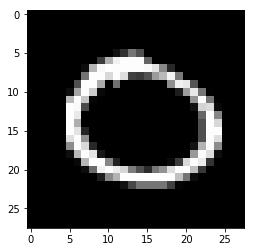

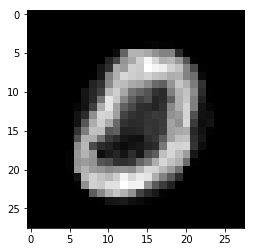

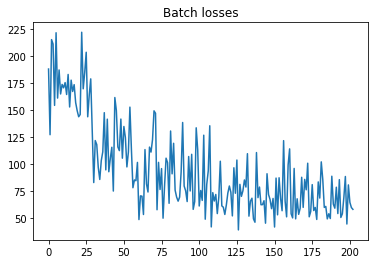

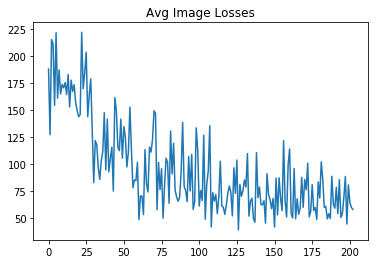

iteration: 200; batch loss: 58.37677764892578, mean img loss: 58.37633514404297


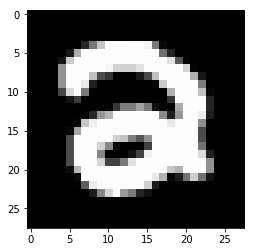

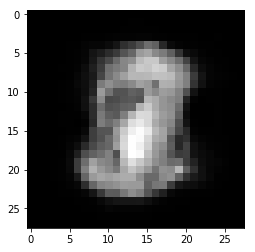

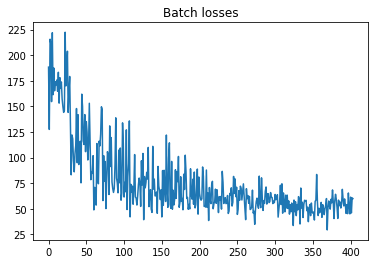

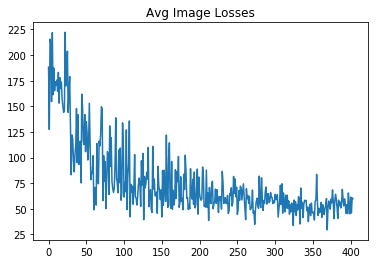

iteration: 400; batch loss: 59.88311767578125, mean img loss: 59.87965774536133


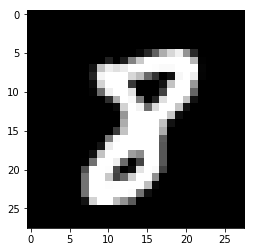

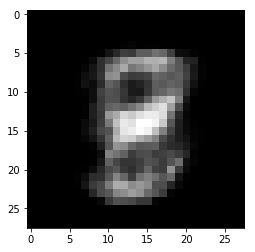

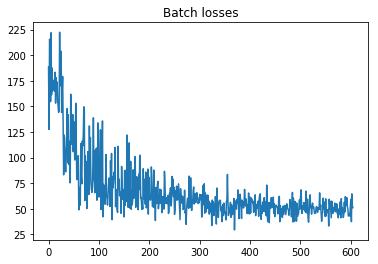

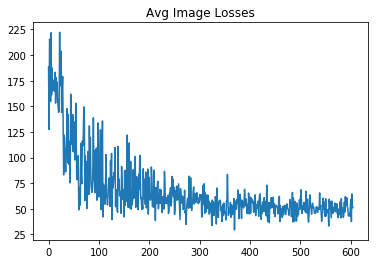

iteration: 600; batch loss: 51.110164642333984, mean img loss: 51.10993194580078


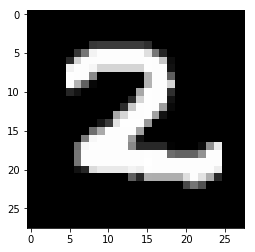

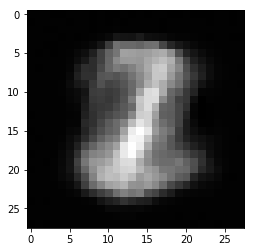

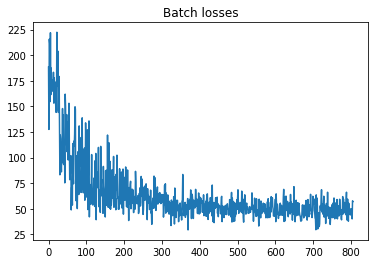

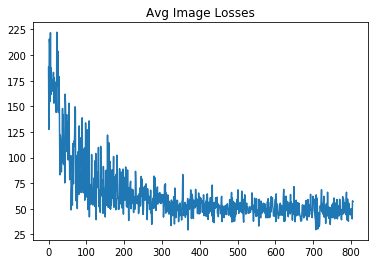

iteration: 800; batch loss: 56.988372802734375, mean img loss: 56.98651123046875


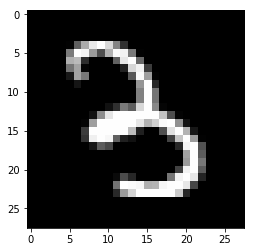

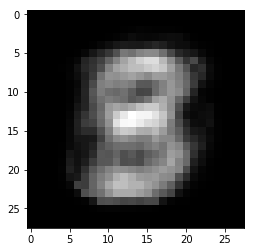

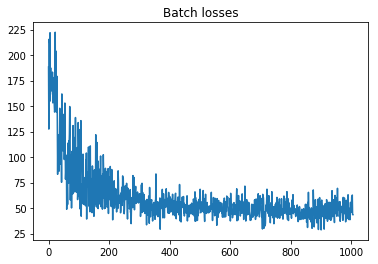

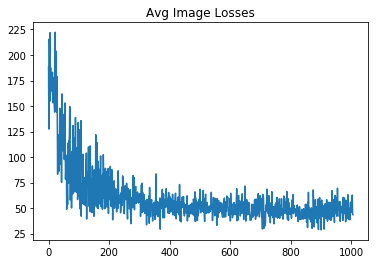

iteration: 1000; batch loss: 43.554588317871094, mean img loss: 43.554359436035156


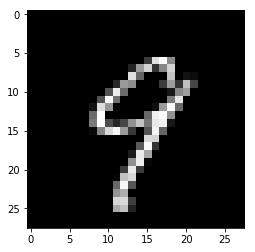

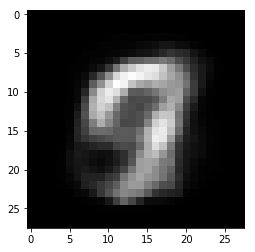

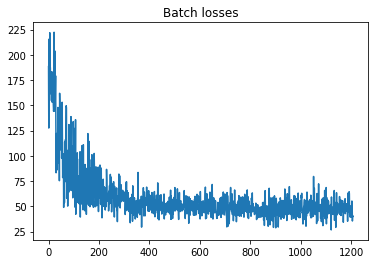

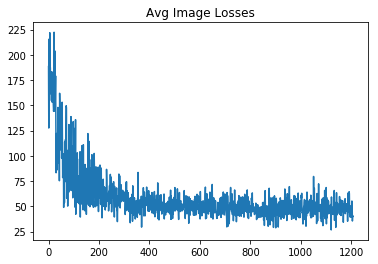

iteration: 1200; batch loss: 39.90121841430664, mean img loss: 39.900691986083984


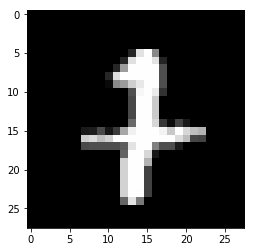

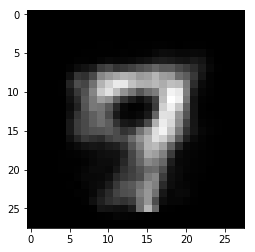

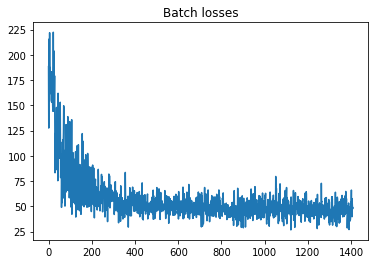

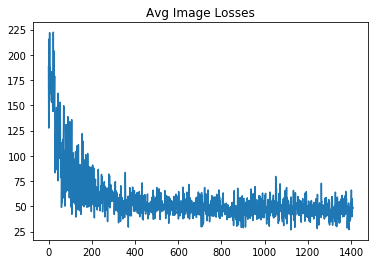

iteration: 1400; batch loss: 47.86237716674805, mean img loss: 47.86223220825195


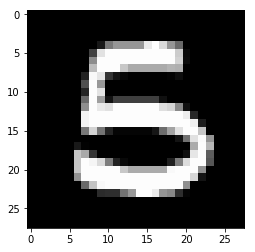

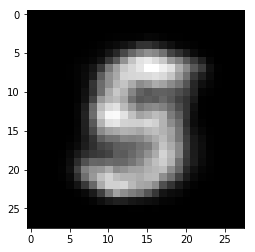

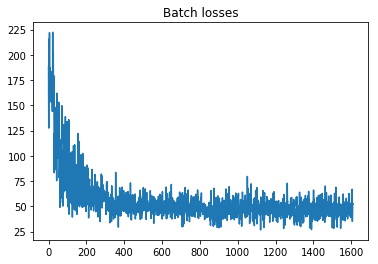

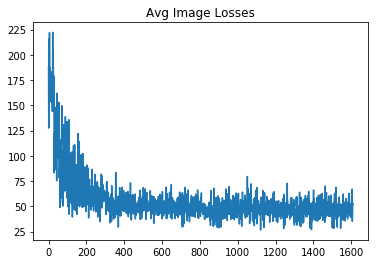

iteration: 1600; batch loss: 52.32386016845703, mean img loss: 52.32382583618164


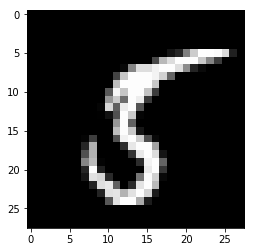

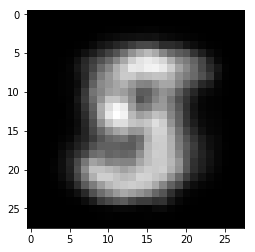

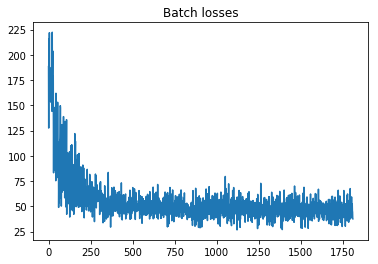

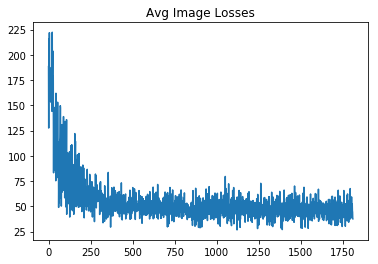

iteration: 1800; batch loss: 37.516021728515625, mean img loss: 37.51601028442383


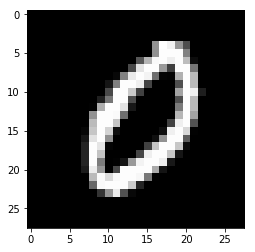

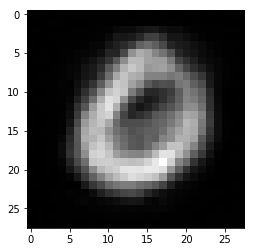

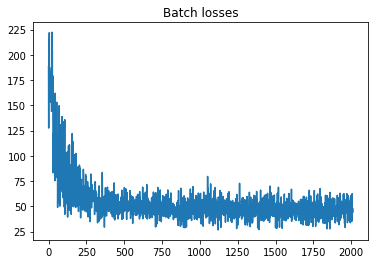

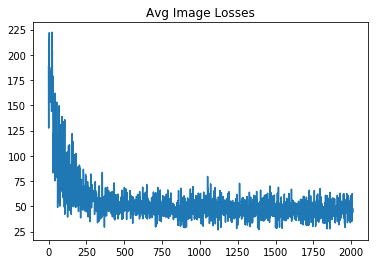

iteration: 2000; batch loss: 44.344303131103516, mean img loss: 44.344215393066406


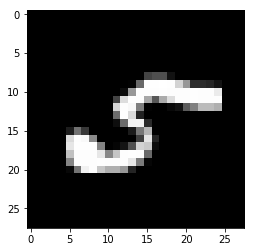

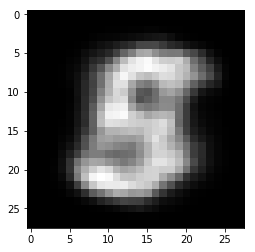

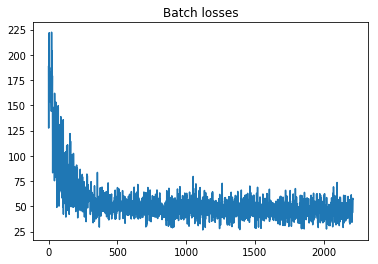

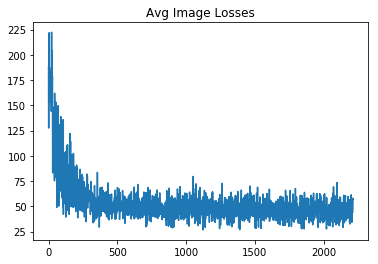

iteration: 2200; batch loss: 57.31568145751953, mean img loss: 57.315582275390625


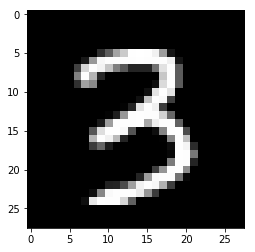

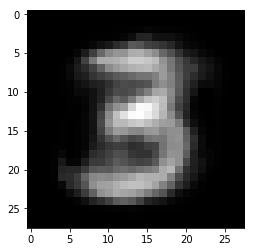

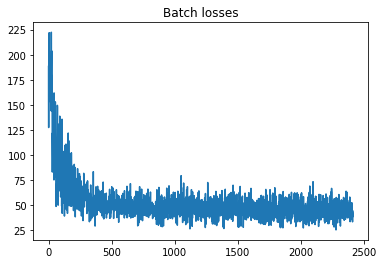

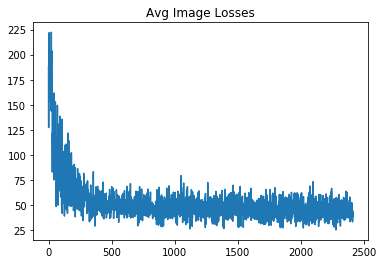

iteration: 2400; batch loss: 38.91911697387695, mean img loss: 38.91902542114258


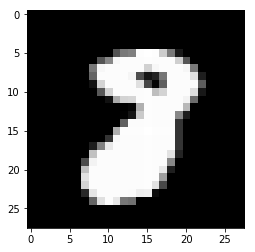

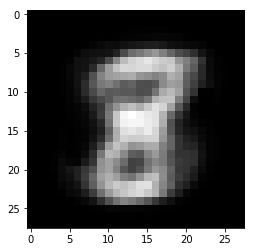

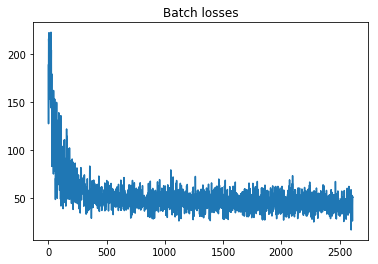

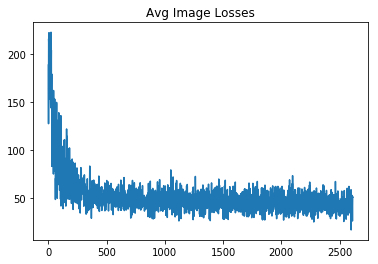

iteration: 2600; batch loss: 51.27370071411133, mean img loss: 51.273685455322266


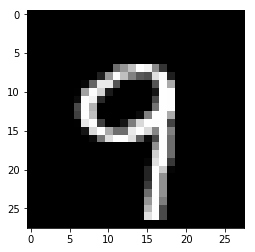

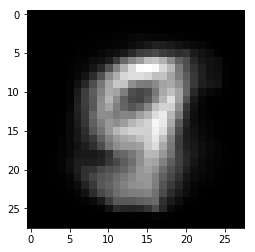

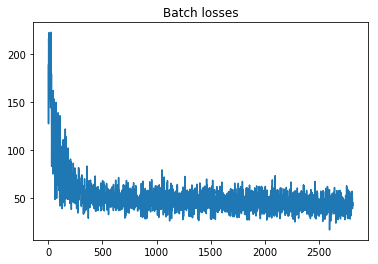

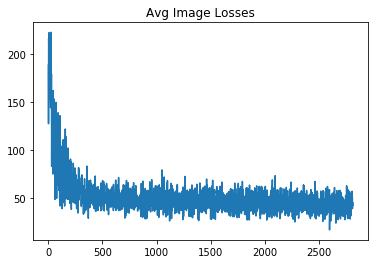

iteration: 2800; batch loss: 42.972869873046875, mean img loss: 42.972755432128906


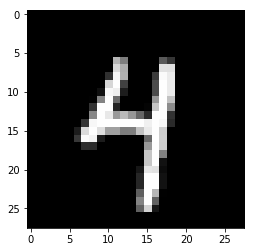

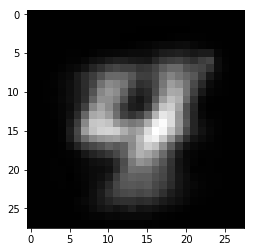

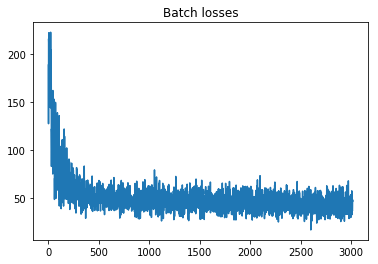

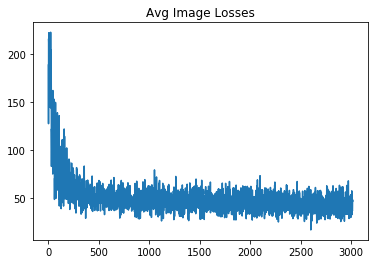

iteration: 3000; batch loss: 47.2493896484375, mean img loss: 47.24934387207031


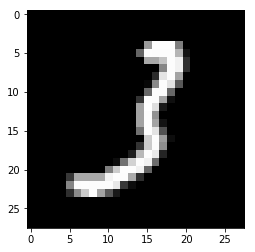

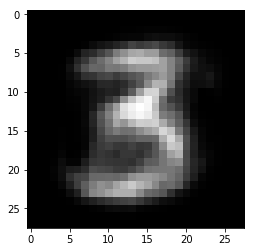

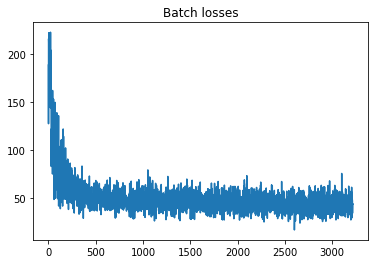

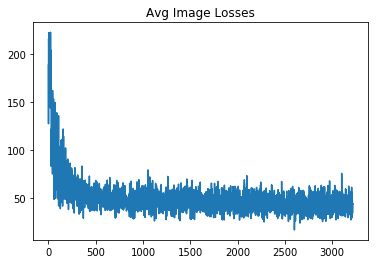

iteration: 3200; batch loss: 44.227294921875, mean img loss: 44.22721481323242


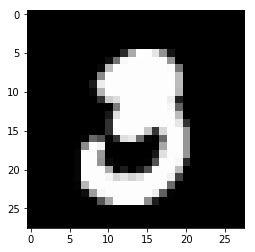

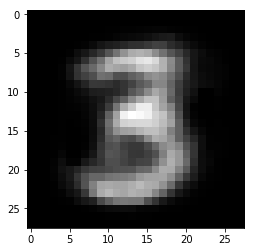

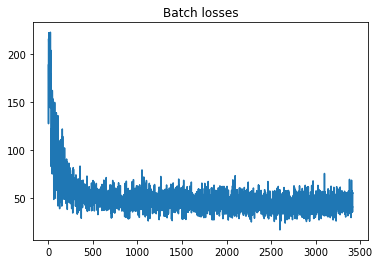

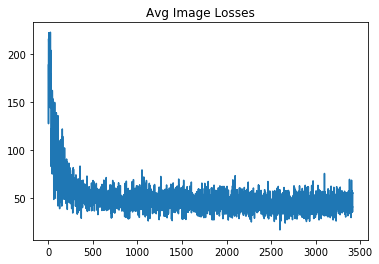

iteration: 3400; batch loss: 55.55628204345703, mean img loss: 55.55623245239258


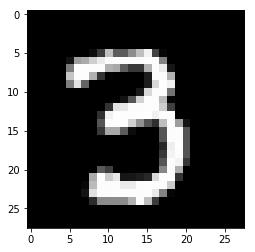

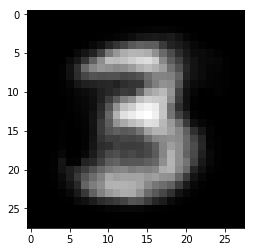

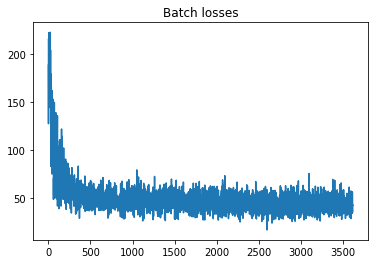

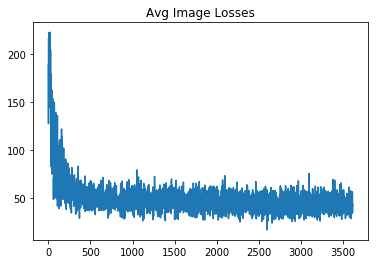

iteration: 3600; batch loss: 36.07140350341797, mean img loss: 36.071372985839844


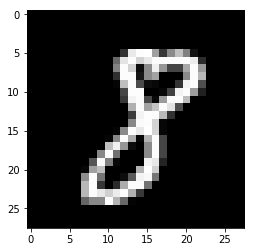

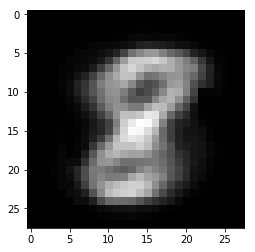

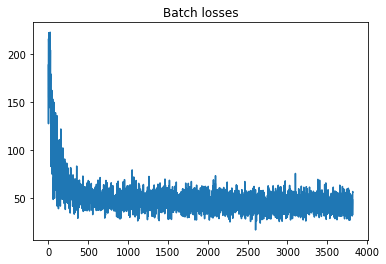

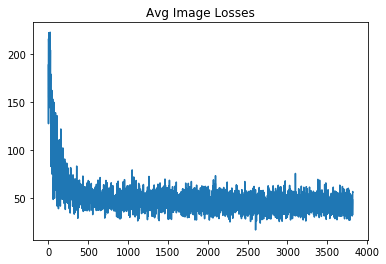

iteration: 3800; batch loss: 56.595298767089844, mean img loss: 56.595237731933594


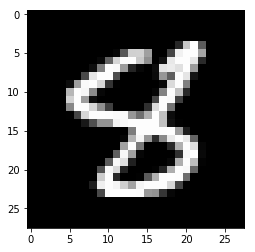

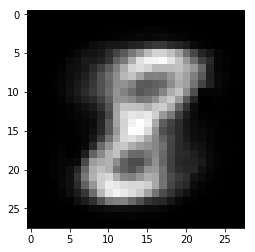

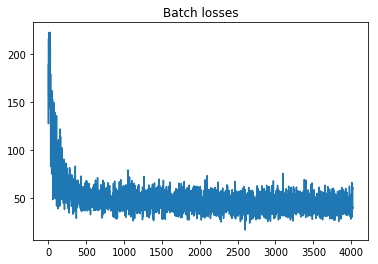

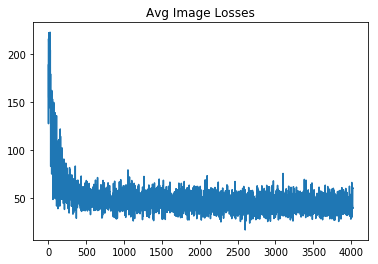

iteration: 4000; batch loss: 60.444984436035156, mean img loss: 60.444950103759766


In [23]:
batch_losses = []
avg_img_losses = []

for i in range(4001):
    next_batch = mnist.train.next_batch(batch_size=batch_size)
    batch = np.array([np.reshape(b, [28, 28, 1]) for b in next_batch[0]])
    labels = np.array([l for l in next_batch[1]], dtype=np.int32)
    # sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 0.8})
    batch_loss, batch_img_loss, _ = sess.run([loss, img_loss, optimizer], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 0.8})
    batch_losses.append(batch_loss)
    avg_img_losses.append(np.mean(batch_img_loss))
        
    if not i % 200:
        batch_loss, decoded, batch_img_loss, mu, sigm = sess.run([loss, dec, img_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 1.0})
        batch_losses.append(batch_loss)
        avg_img_losses.append(np.mean(batch_img_loss))
        
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(decoded[0], cmap='gray')
        plt.show()
        
        plt.title('Batch losses')
        plt.plot(np.arange(len(batch_losses)), batch_losses)
        plt.show()
        
        plt.title('Avg Image Losses')
        plt.plot(np.arange(len(avg_img_losses)), avg_img_losses)
        plt.show()
        print('iteration: {}; batch loss: {}, mean img loss: {}'.format(i, batch_loss, np.mean(batch_img_loss)))

##### Constant Learning Rate

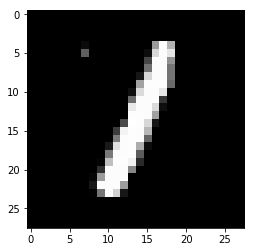

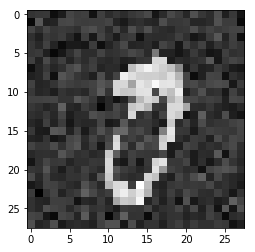

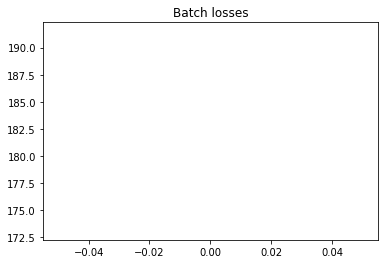

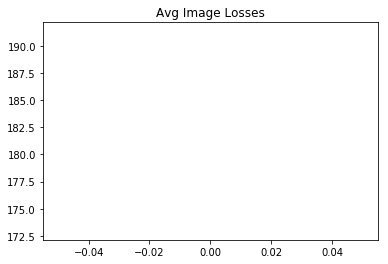

iteration: 0; batch loss: 147.86770629882812, mean img loss: 147.82748413085938


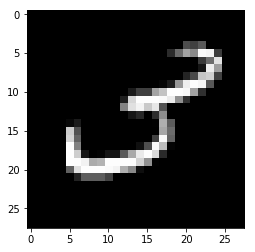

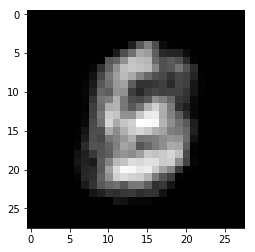

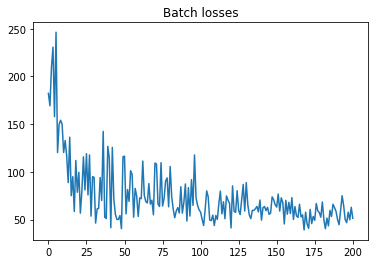

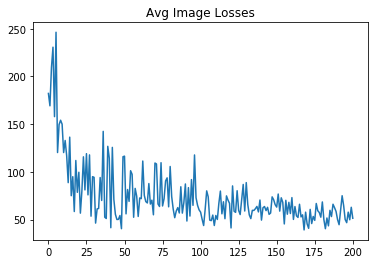

iteration: 200; batch loss: 49.807952880859375, mean img loss: 49.80791473388672


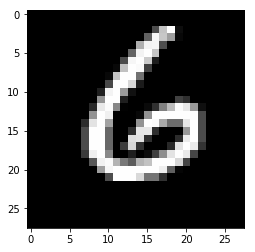

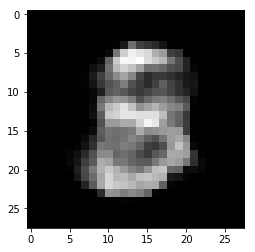

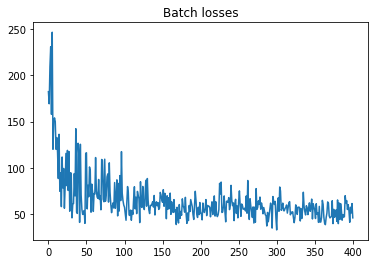

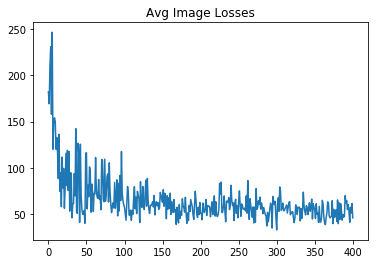

iteration: 400; batch loss: 45.439857482910156, mean img loss: 45.43976974487305


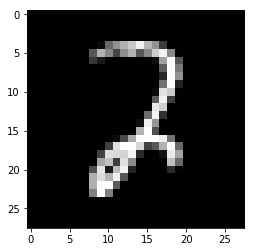

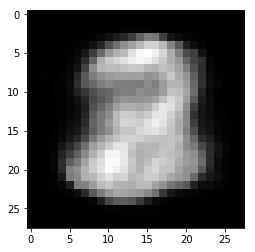

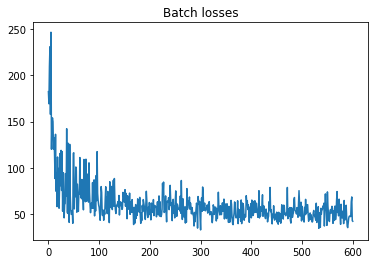

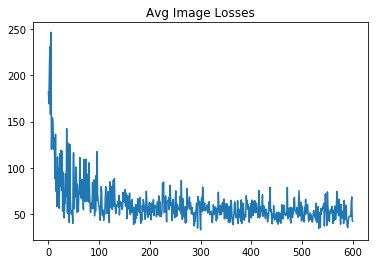

iteration: 600; batch loss: 42.01706314086914, mean img loss: 42.016937255859375


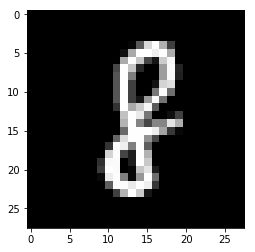

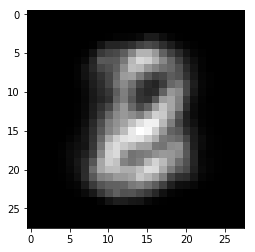

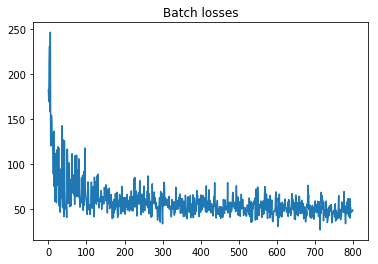

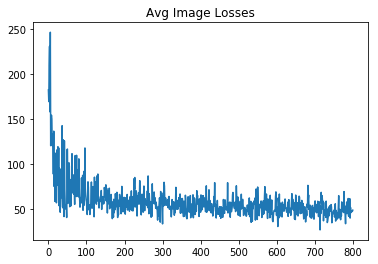

iteration: 800; batch loss: 48.36638641357422, mean img loss: 48.36625671386719


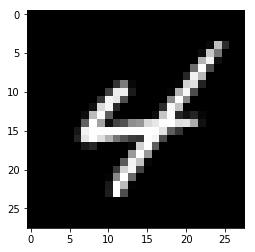

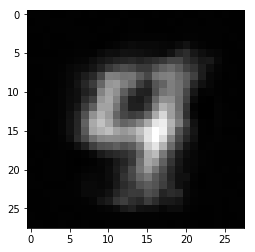

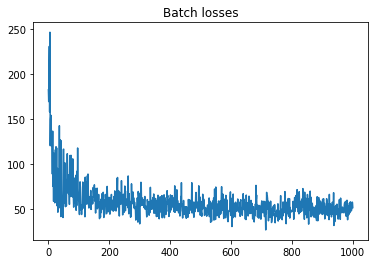

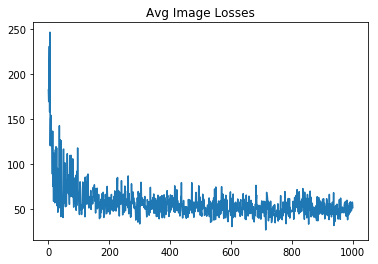

iteration: 1000; batch loss: 50.920555114746094, mean img loss: 50.92053985595703


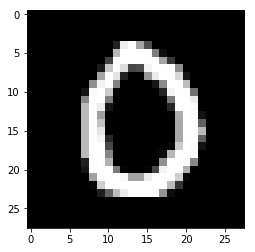

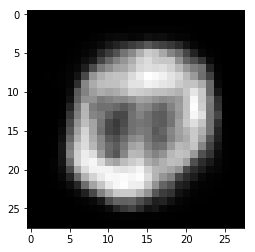

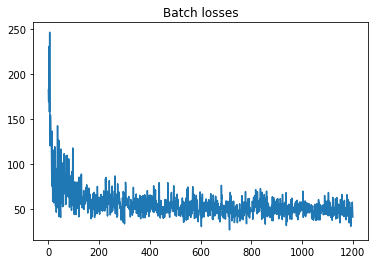

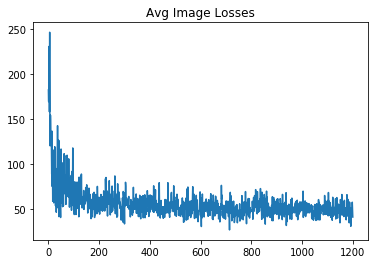

iteration: 1200; batch loss: 40.72825622558594, mean img loss: 40.72817611694336


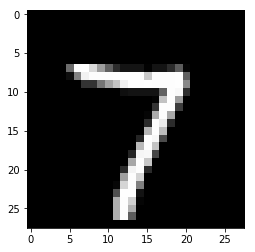

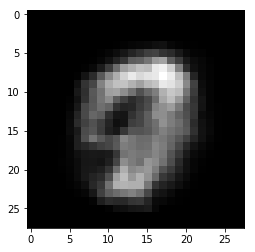

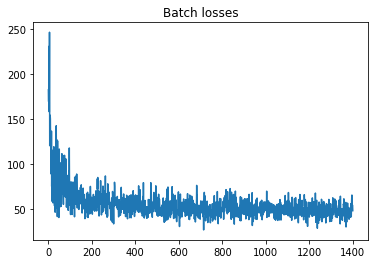

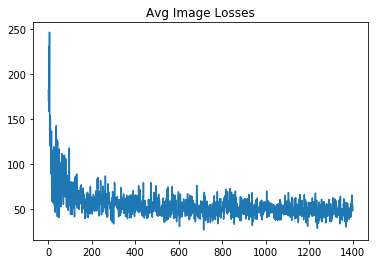

iteration: 1400; batch loss: 47.517555236816406, mean img loss: 47.51717758178711


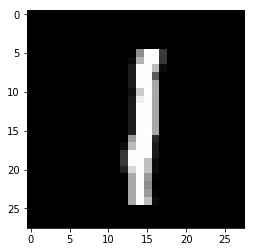

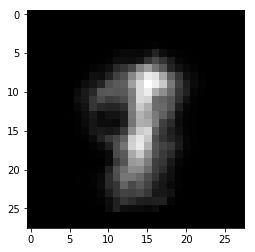

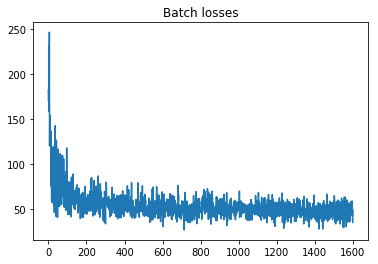

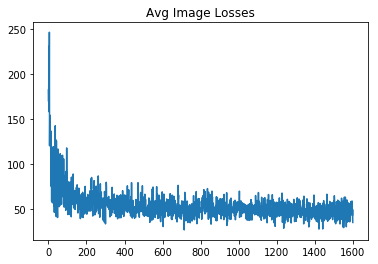

iteration: 1600; batch loss: 34.4232177734375, mean img loss: 34.422969818115234


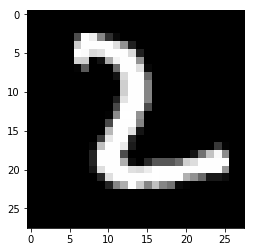

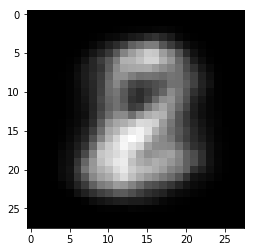

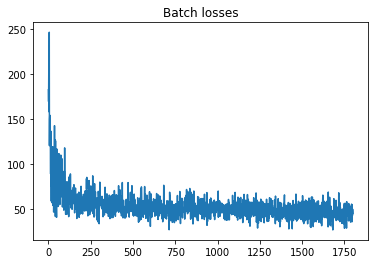

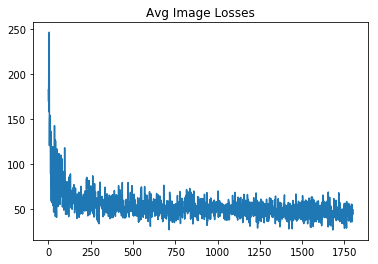

iteration: 1800; batch loss: 44.06004333496094, mean img loss: 44.05984115600586


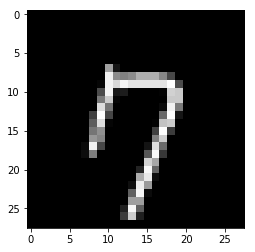

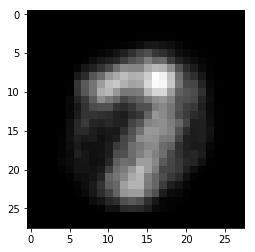

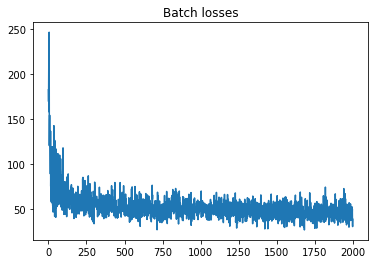

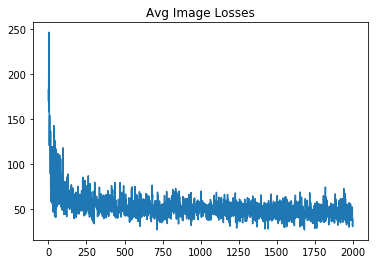

iteration: 2000; batch loss: 37.27863693237305, mean img loss: 37.278629302978516


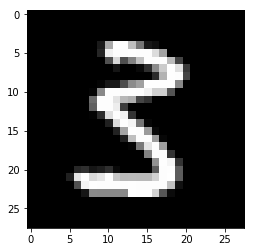

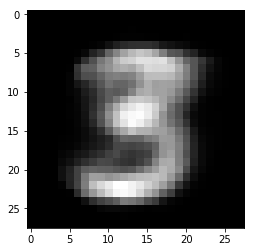

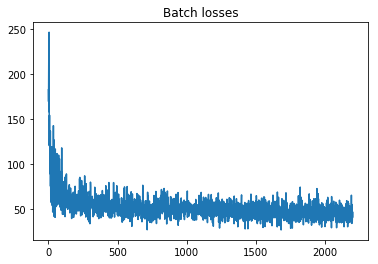

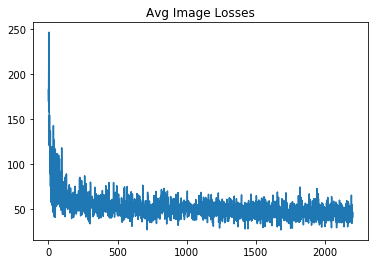

iteration: 2200; batch loss: 38.26862335205078, mean img loss: 38.26860046386719


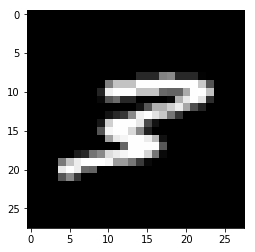

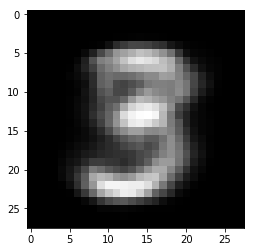

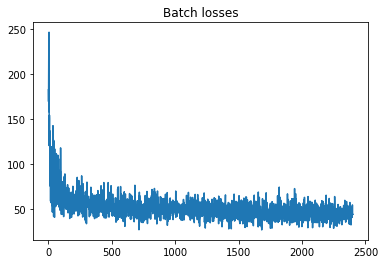

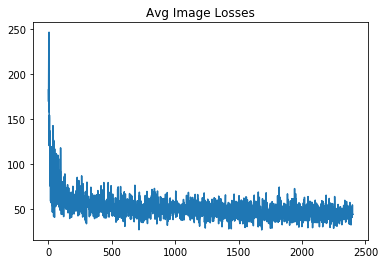

iteration: 2400; batch loss: 43.67376708984375, mean img loss: 43.67373275756836


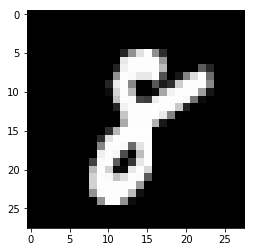

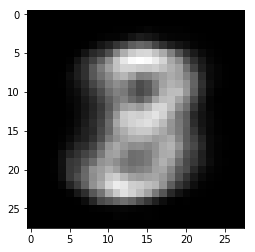

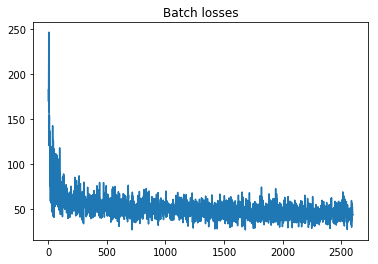

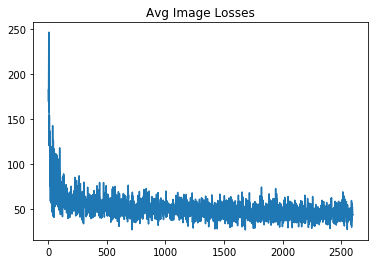

iteration: 2600; batch loss: 42.53746795654297, mean img loss: 42.53730773925781


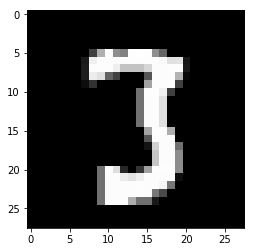

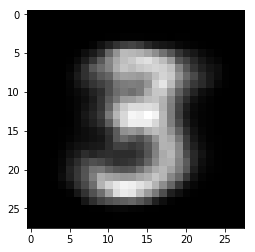

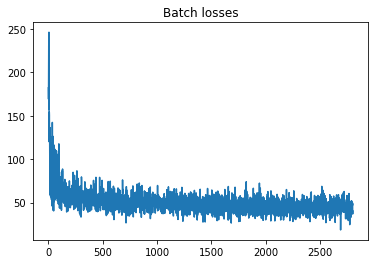

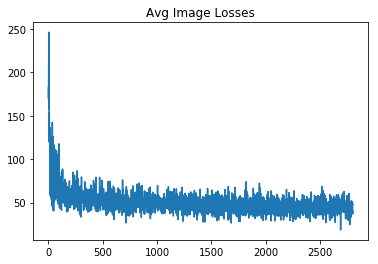

iteration: 2800; batch loss: 39.86793899536133, mean img loss: 39.86787414550781


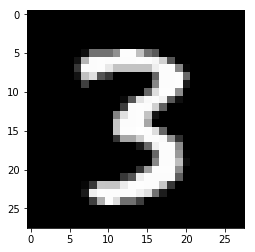

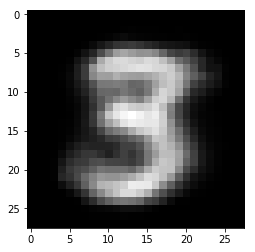

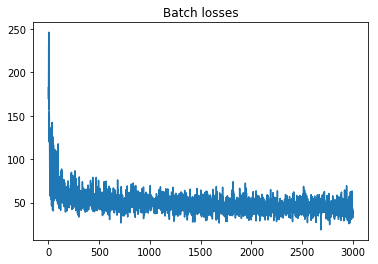

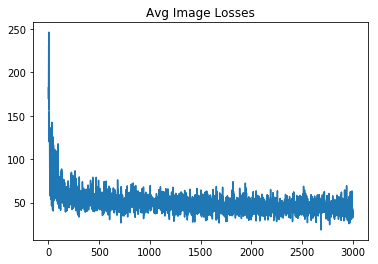

iteration: 3000; batch loss: 39.66191101074219, mean img loss: 39.661888122558594


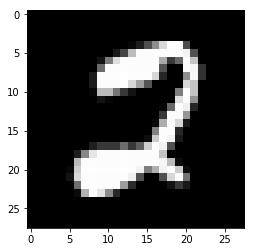

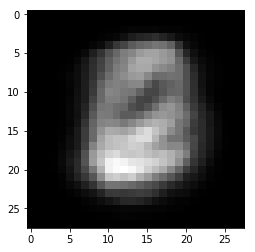

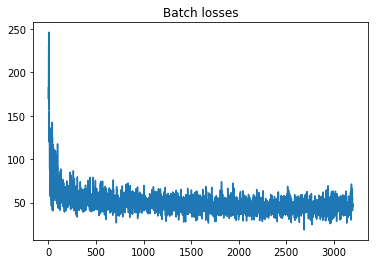

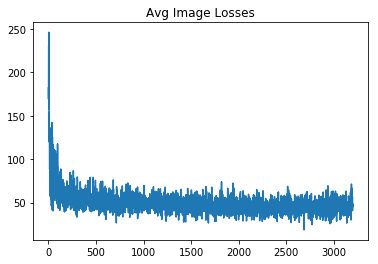

iteration: 3200; batch loss: 48.01007080078125, mean img loss: 48.010047912597656


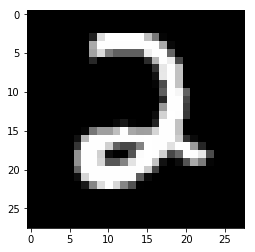

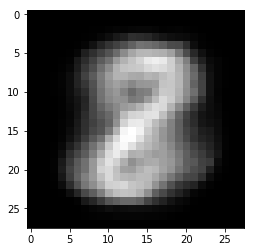

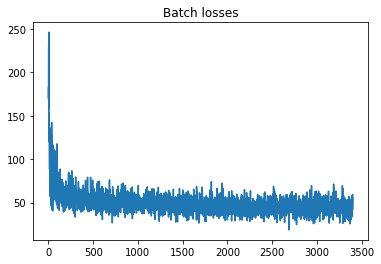

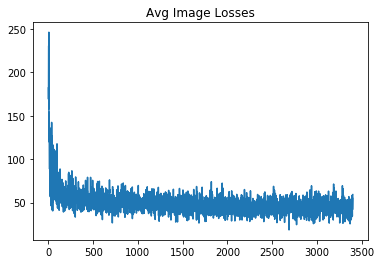

iteration: 3400; batch loss: 58.426387786865234, mean img loss: 58.42633056640625


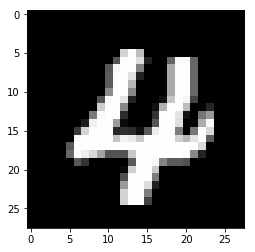

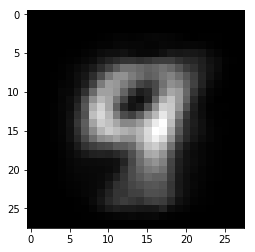

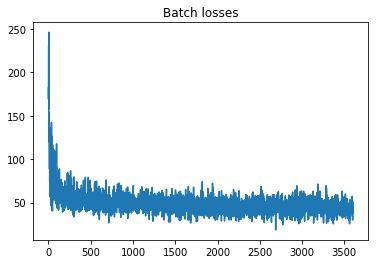

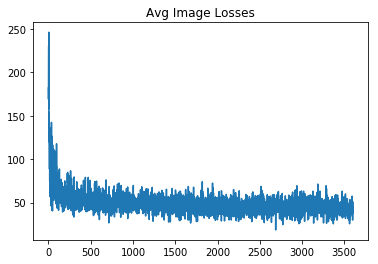

iteration: 3600; batch loss: 37.82275390625, mean img loss: 37.82259750366211


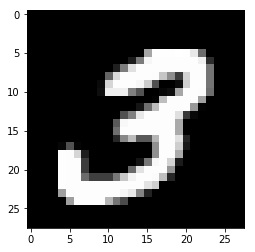

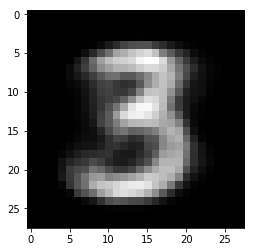

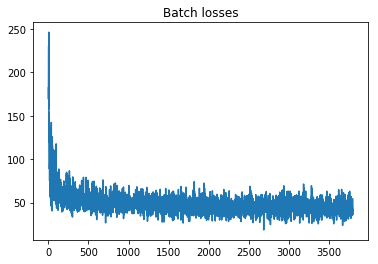

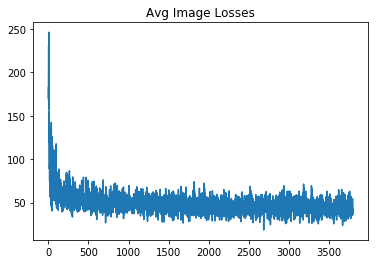

iteration: 3800; batch loss: 53.38419723510742, mean img loss: 53.384033203125


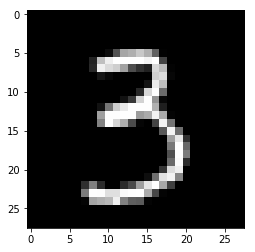

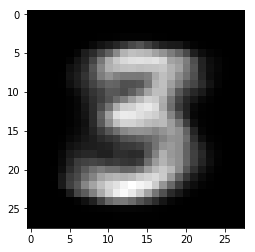

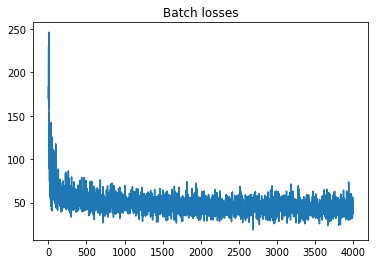

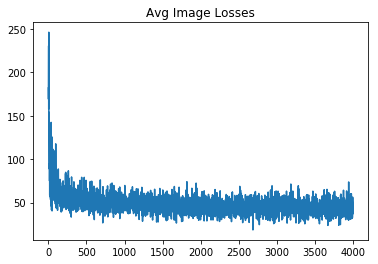

iteration: 4000; batch loss: 49.46820068359375, mean img loss: 49.46810531616211


In [19]:
batch_losses = []
avg_img_losses = []

for i in range(4001):
    next_batch = mnist.train.next_batch(batch_size=batch_size)
    batch = np.array([np.reshape(b, [28, 28, 1]) for b in next_batch[0]])
    labels = np.array([l for l in next_batch[1]], dtype=np.int32)
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 0.8})
#     batch_loss, batch_img_loss, _ = sess.run([loss, img_loss, optimizer], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 0.8})
#     batch_losses.append(batch_loss)
#     avg_img_losses.append(np.mean(batch_img_loss))
        
    if not i % 200:
        batch_loss, decoded, batch_img_loss, mu, sigm = sess.run([loss, dec, img_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 1.0})
        batch_losses.append(batch_loss)
        avg_img_losses.append(np.mean(batch_img_loss))
        
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(decoded[0], cmap='gray')
        plt.show()
        
        plt.title('Batch losses')
        plt.plot(np.arange(len(batch_losses)), batch_losses)
        plt.show()
        
        plt.title('Avg Image Losses')
        plt.plot(np.arange(len(avg_img_losses)), avg_img_losses)
        plt.show()
        print('iteration: {}; batch loss: {}, mean img loss: {}'.format(i, batch_loss, np.mean(batch_img_loss)))

### Generate New Images

##### Variable Learning Rate

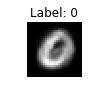

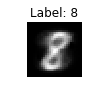

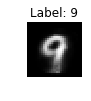

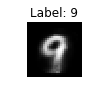

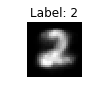

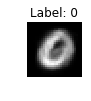

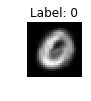

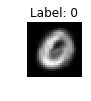

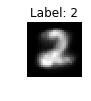

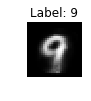

In [24]:
n_samples = 10
randoms = [np.random.normal(0, 1, n_latent) for _ in range(n_samples)]
labels = [np.random.choice(n_classes) for _ in range(n_samples)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, Labels: labels, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for i, img in enumerate(imgs):
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.title('Label: {}'.format(labels[i]))
    plt.imshow(img, cmap='gray')

##### Constant Learning Rate

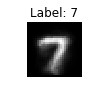

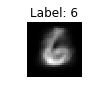

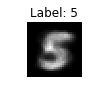

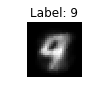

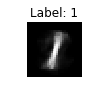

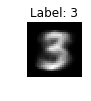

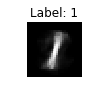

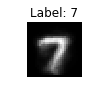

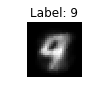

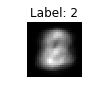

In [20]:
n_samples = 10
randoms = [np.random.normal(0, 1, n_latent) for _ in range(n_samples)]
labels = [np.random.choice(n_classes) for _ in range(n_samples)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, Labels: labels, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for i, img in enumerate(imgs):
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.title('Label: {}'.format(labels[i]))
    plt.imshow(img, cmap='gray')